In [411]:
library(dplyr)
library(lme4)
library(nlme)
library(purrr)
library(performance)
library(tibble)
library(MuMIn)
library(here)
library(reactablefmtr)
library(emmeans)
library(car)
library(ggplot2)
library(modelr)
require(vegan)
require(knitr)
require(ggpubr)
library(ggeffects)
library(janitor)
library(sjPlot)
library(factoextra)
library(arm)

In [412]:
setwd(here::here())

In [458]:
# Load all joined dataset
source("./scripts/code_join_data_full_dataset.R")

In [459]:
# Load custom made functions
source("./R/functions_models.R")
source("./R/function_plots.R")
source("./R/function_validation_plots.R")
source("./R/function_for_inference_emmeans_and_percentage_diff.R")

In [460]:
# set plot dimensions
options(repr.plot.width = 15)
options(repr.plot.height = 10)

__For running each peice of code press shift + Enter__

# __Q3:How do functional traits, treatment, and N-fixing status interact to influence seedling-level growth rates and biomass accumulation?__


In [465]:
# Select variables that are going to be used in the model
data_for_models <-
    data_for_models %>%

    clean_names() %>%
    # Select columns needed for regression
    dplyr::select(spcode, treatment, nfixer, init_height,

                  # Performance measures
                  total_biomass, rgr, root_shoot_ratio,

                  # physiology traits
                  amax, gs, wue,pnue,sla,

                  # Leaf traits
                  narea_g_m2) %>%
    clean_names()

## Regression models 

$$response\sim treatment*trait\ +nfixer*trait\ + initial\ height\ + random(1|specie)$$

In [477]:
data_plant_performance <-
    data_for_models %>%
        dplyr::select(-c(amax, gs,wue, narea_g_m2,	sla, pnue, init_height))

In [478]:
# Center and scale by 2 as Gelman et al 2008

data_traits_scaled_gelman <-
        data_for_models %>%
                dplyr::select(-c(total_biomass, rgr, root_shoot_ratio)) %>%
                mutate(across(where(is.numeric), arm::rescale))

In [479]:
data_for_regression_scaled_traits <-
    inner_join(data_plant_performance, data_traits_scaled_gelman, by = c("treatment","spcode", "nfixer"))

Warning message in inner_join(data_plant_performance, data_traits_scaled_gelman, :
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 1 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


In [480]:
# add t-ratio
emm_options(contrast = list(infer = c(TRUE, TRUE)))

### Total biomass

In [484]:
model_pc_total_biomass <- lmer(total_biomass ~  treatment * amax +
                                                treatment * gs  +
                                                treatment * sla +
                                                treatment * pnue +

                                                nfixer * amax +
                                                nfixer * gs  +
                                                nfixer * sla +
                                                nfixer * pnue +


                            (1 |spcode) +

                            # Control over different plant heights
                            init_height,

                        data = data_for_regression_scaled_traits)


### Relative Growth Rate

In [485]:
model_pc_rgr <- lmer(rgr ~  treatment * amax +
                            treatment * gs  +
                            treatment * sla +
                            treatment * pnue +

                            nfixer * amax +
                            nfixer * gs  +
                            nfixer * sla +
                            nfixer * pnue +

                            (1|spcode) +

                            # Control over different plant heights
                            init_height,

                        data = data_for_regression_scaled_traits)

### Root to shoot ratio

In [486]:
model_pc_root_shoot <- lmer(root_shoot_ratio ~  treatment * amax +
                                                treatment * gs  +
                                                treatment * sla +
                                                treatment * pnue +

                                                nfixer * amax +
                                                nfixer * gs  +
                                                nfixer * sla +
                                                nfixer * pnue +

                            (1|spcode) +

                            # Control over different plant heights
                            init_height,

                        data = data_for_regression_scaled_traits)

## Model Assumptions

[1] "No variable specified inthe variables argument"


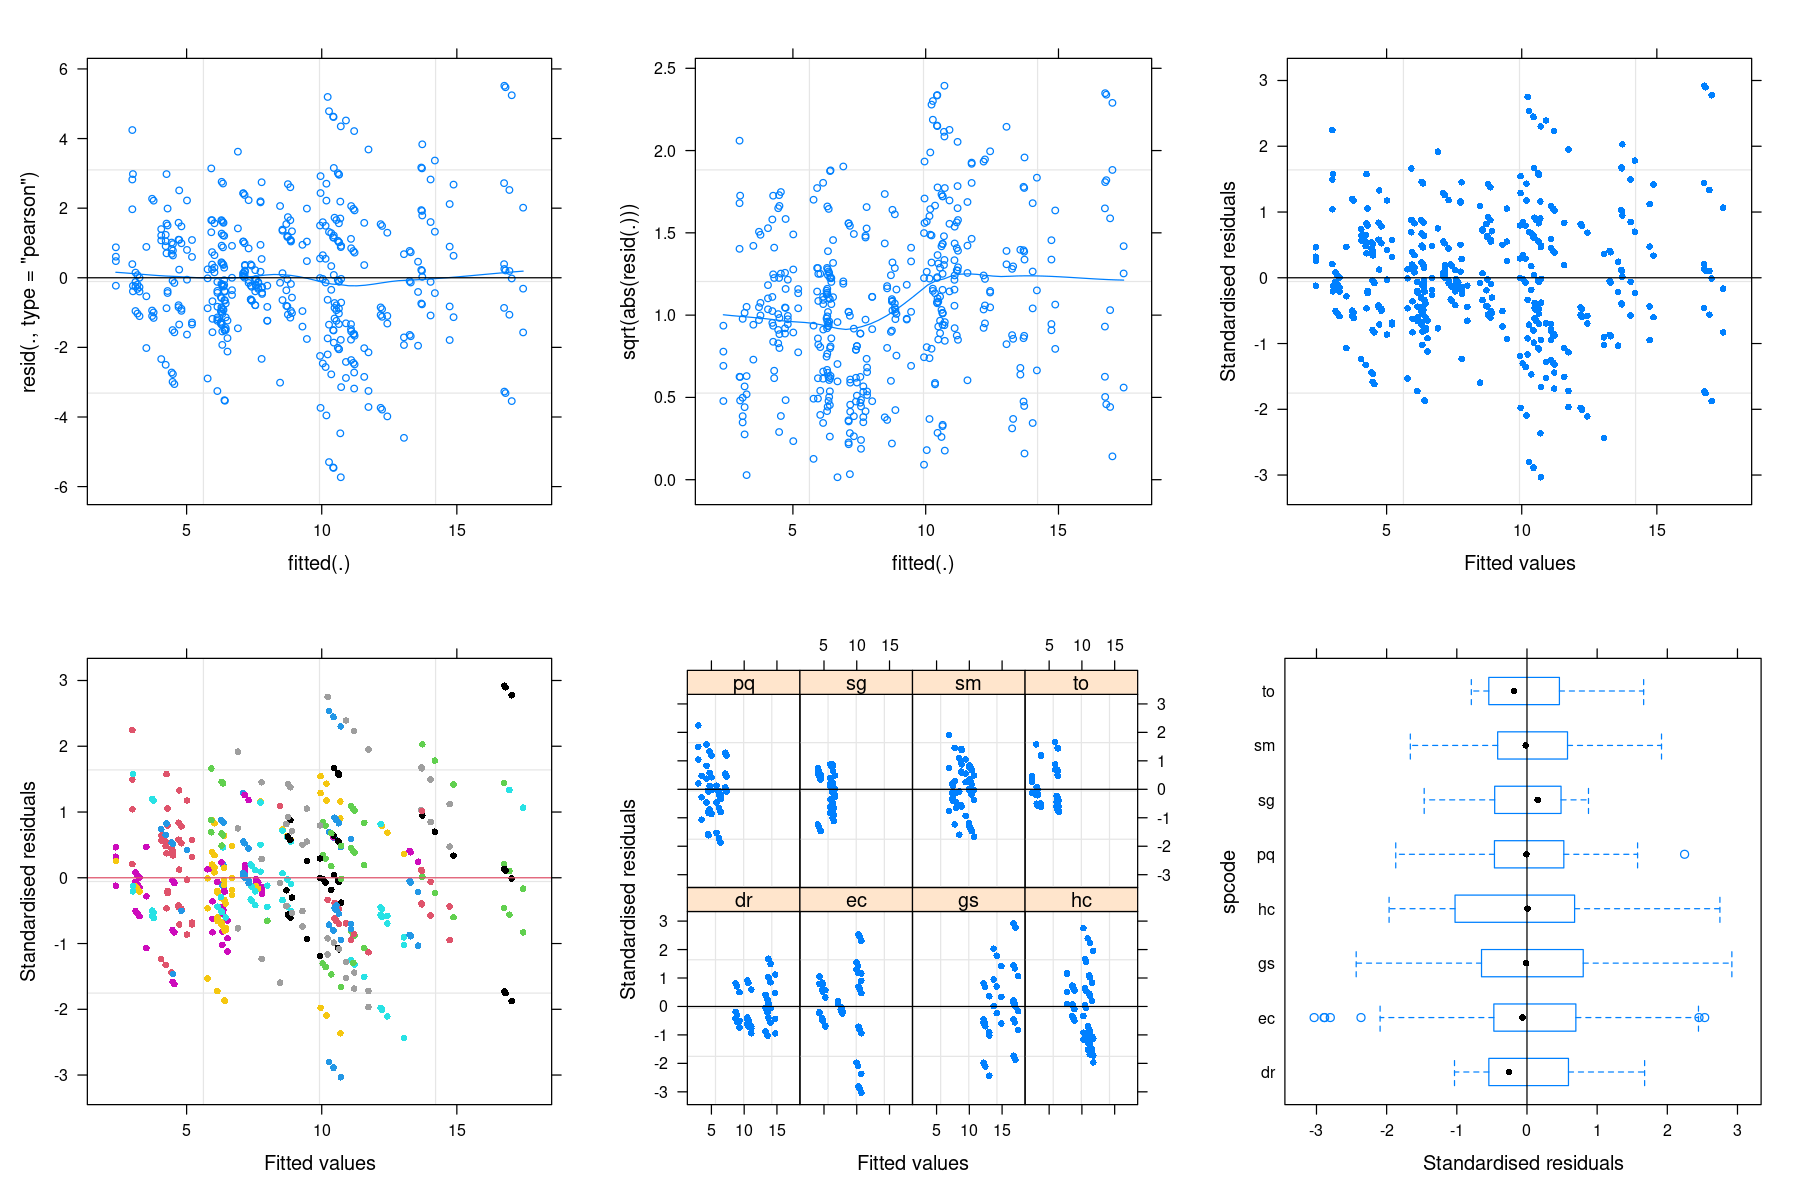

In [487]:
par(mfrow = c(3,3))
validation_plots(model_pc_total_biomass, data = data_for_models,group = "spcode")

[1] "No variable specified inthe variables argument"


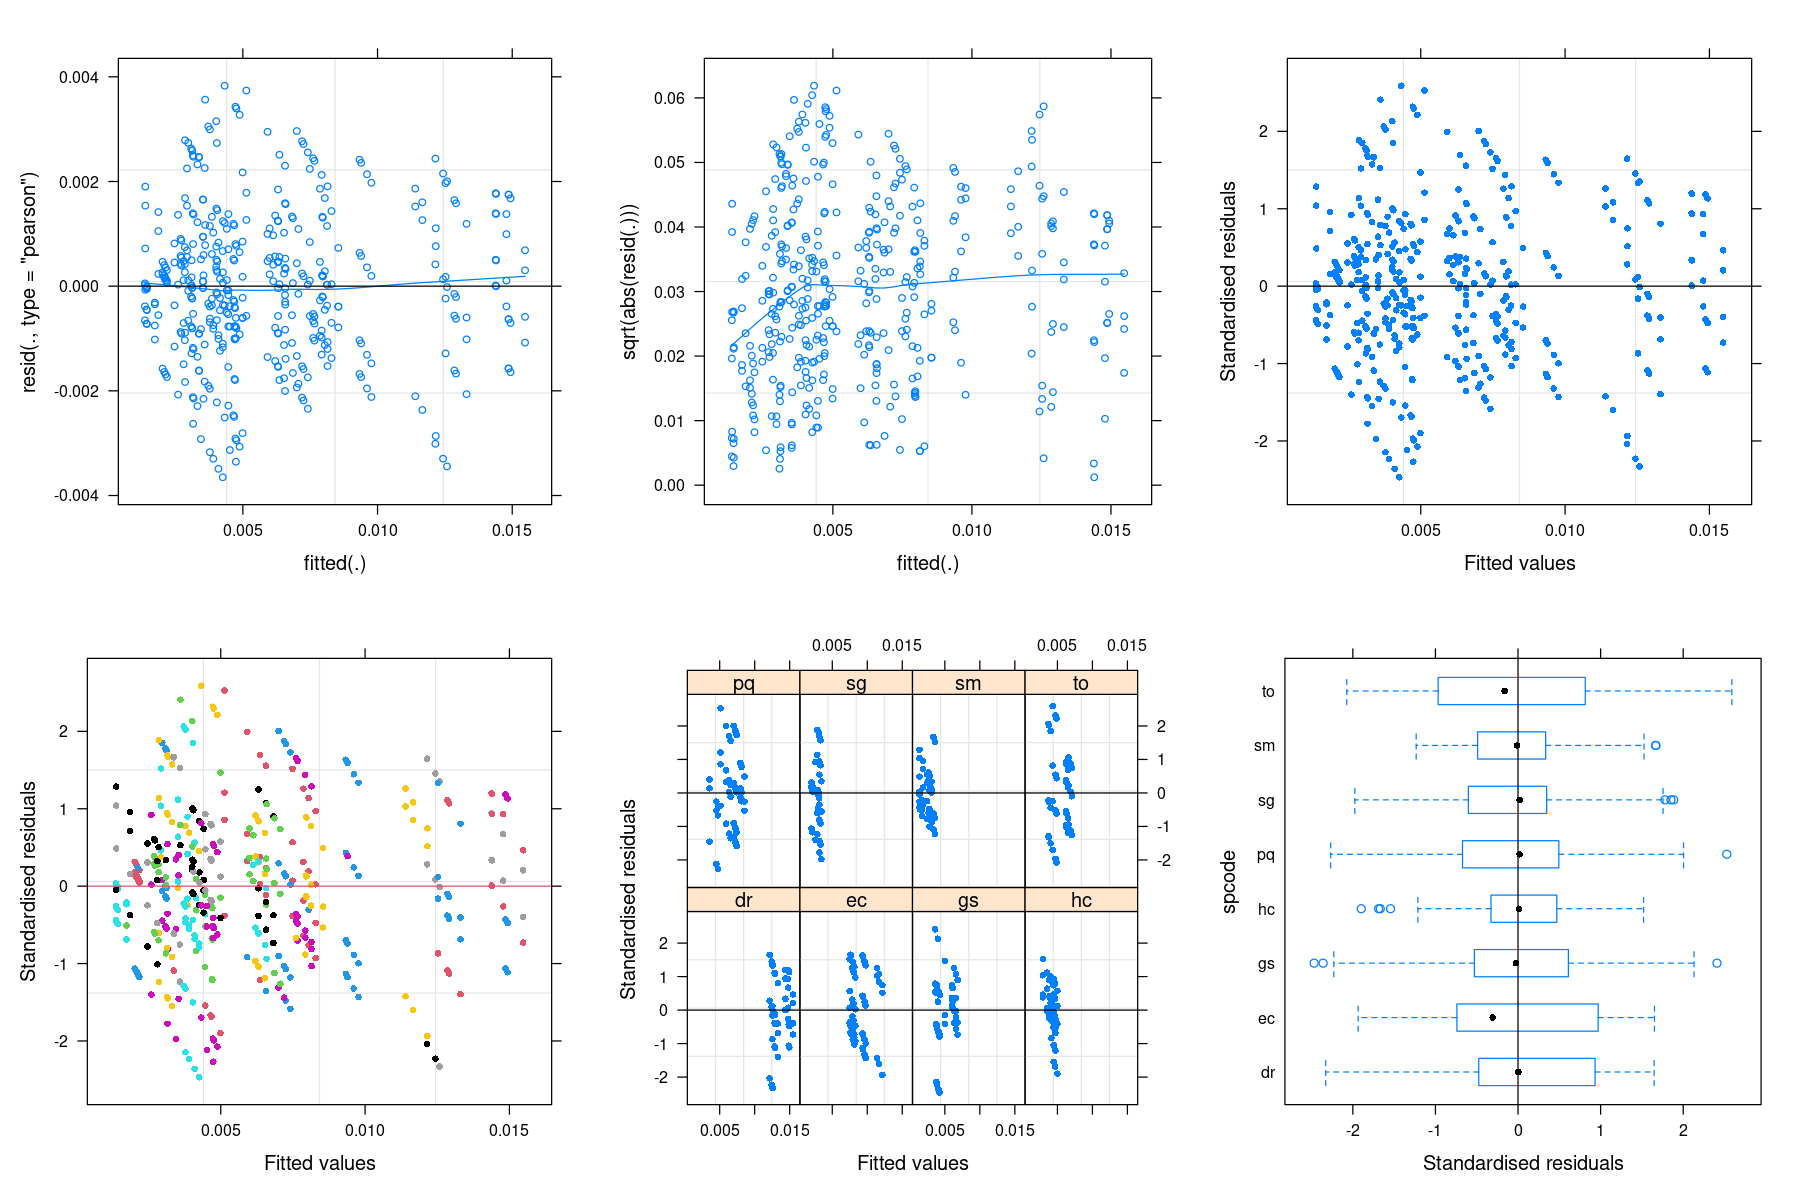

In [488]:
par(mfrow = c(3,3))
validation_plots(model_pc_rgr, data = data_for_models,group = "spcode")

[1] "No variable specified inthe variables argument"


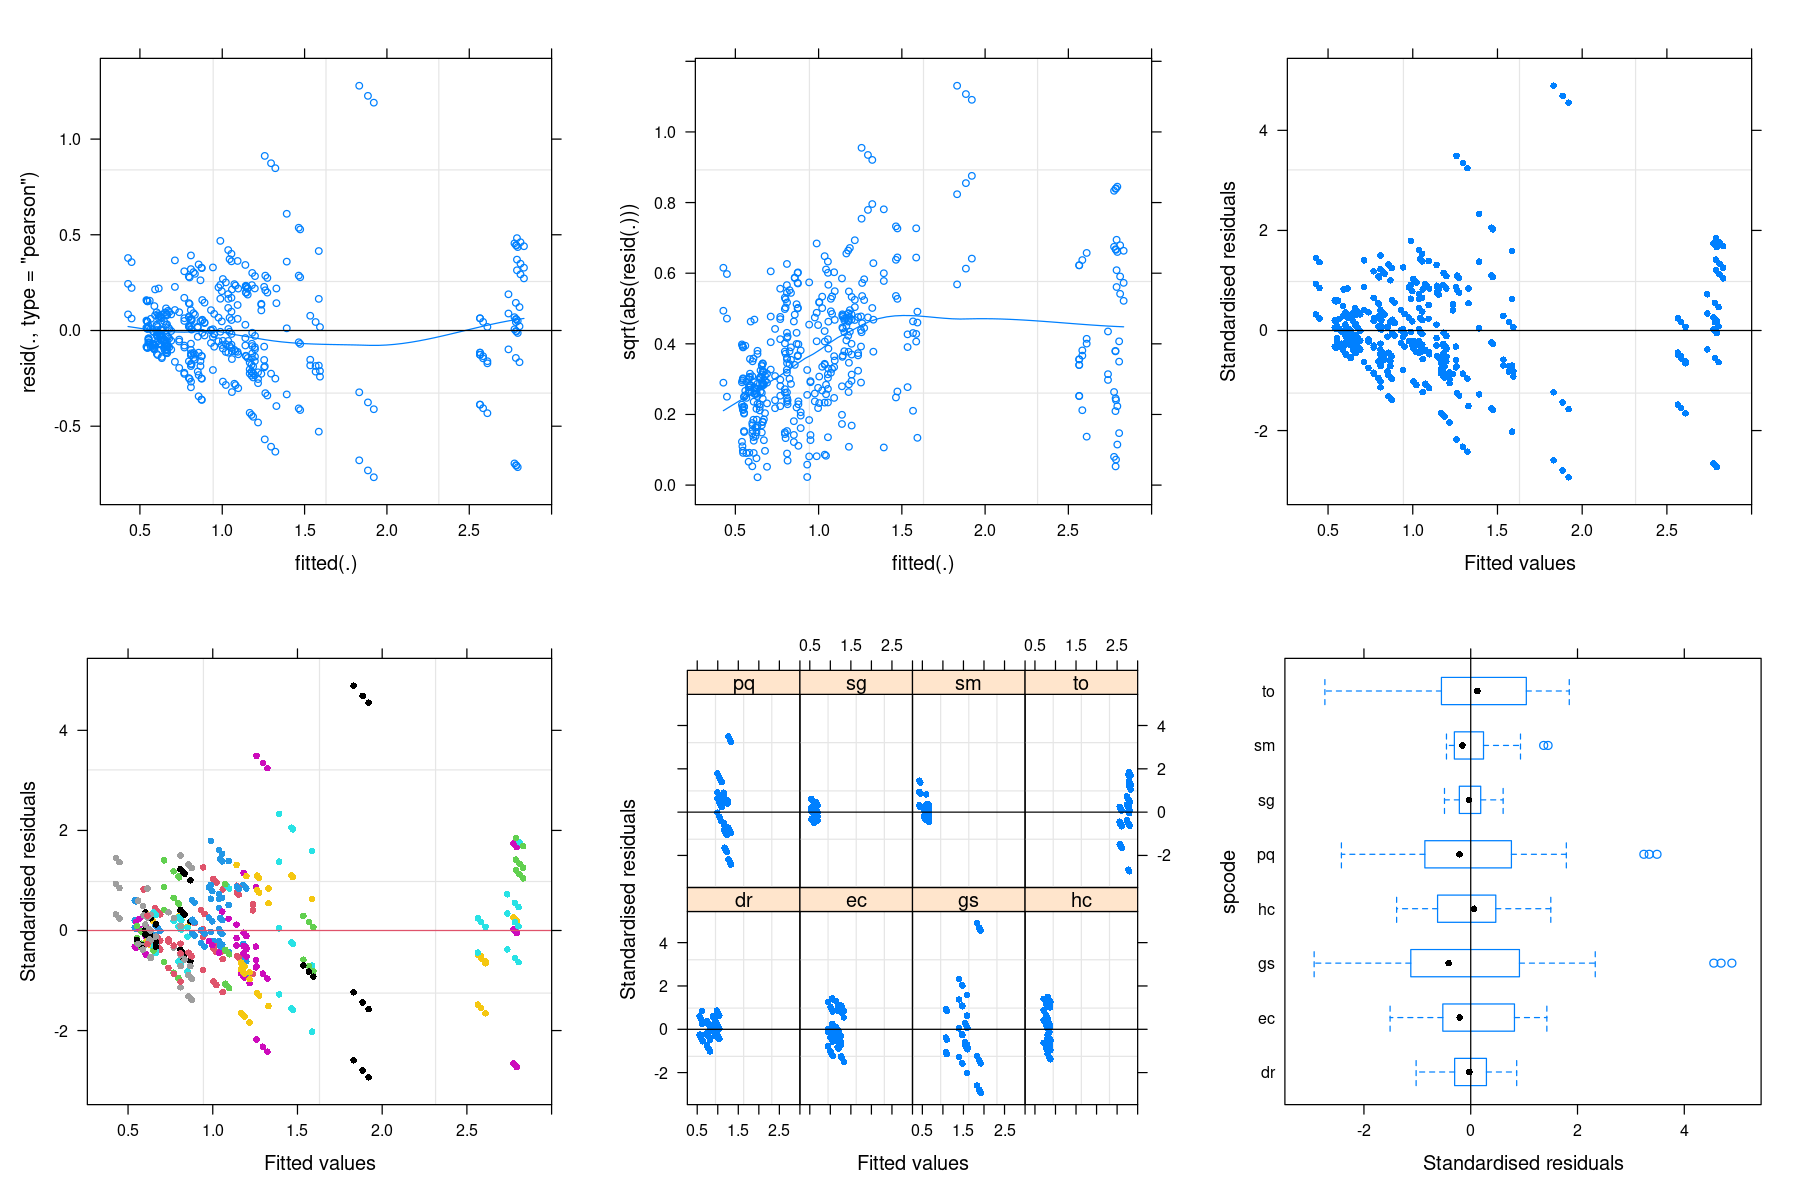

In [489]:
par(mfrow = c(3,3))
validation_plots(model_pc_root_shoot, data = data_for_models,group = "spcode")

## Model inference

In [491]:
## r2 models

r2(model_pc_total_biomass) %>%
    kable()



| R2_conditional| R2_marginal|optional |
|--------------:|-----------:|:--------|
|      0.8069752|    0.396141|FALSE    |

In [492]:
r2(model_pc_rgr) %>%
    kable()



| R2_conditional| R2_marginal|optional |
|--------------:|-----------:|:--------|
|      0.8763222|   0.3852113|FALSE    |

In [493]:
r2(model_pc_root_shoot) %>%
    kable()



| R2_conditional| R2_marginal|optional |
|--------------:|-----------:|:--------|
|      0.8975071|   0.0236171|FALSE    |

## Anova tables

### Total Biomass

In [494]:
Anova(model_pc_total_biomass, type = "III", test.statistic = c("F"))

,F,Df,Df.res,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),8.12512543,1,8.602238,1.994716e-02
treatment,53.59821525,3,406.169149,3.308576e-29
amax,1.32969693,1,399.429097,2.495487e-01
gs,7.68467518,1,405.099188,5.826093e-03
sla,0.08267314,1,406.975209,7.738534e-01
pnue,1.77804981,1,408.957382,1.831312e-01
nfixer,6.05052168,1,7.427149,4.156030e-02
init_height,0.01979438,1,301.497623,8.882068e-01
treatment:amax,5.67085906,3,406.815650,8.196554e-04


#### Amax

In [508]:
emtrends(model_pc_total_biomass,
        pairwise ~ treatment,
        var = "amax")$contrast %>%
        kable()



|contrast                              |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|no_additions - plus_nutrients         | -3.1932972| 1.0851155| 408.2269| -5.9925089| -0.3940855| -2.9428177| 0.0180041|
|no_additions - plus_water             |  0.5543627| 0.7653880| 405.3848| -1.4201229|  2.5288482|  0.7242897| 0.8873696|
|no_additions - plus_water_nutrients   | -1.4346774| 0.7495019| 408.7378| -3.3681154|  0.4987607| -1.9141744| 0.2236419|
|plus_nutrients - plus_water           |  3.7476599| 1.1212856| 407.5065|  0.8551212|  6.6401985|  3.3422885| 0.0050090|
|plus_nutrients - plus_water_nutrients |  1.7586198| 1.1019606| 405.9125| -1.0841131|  4.6013528|  1.5959008| 0.3820844|
|plus_water - plus_water_nutrients     | -1.9890400| 0.6835027| 406.2207| -3.7522696| -0.2258105| -2.9100690| 0.0198574|

In [509]:
emtrends(model_pc_total_biomass,
        pairwise ~ treatment,
        var = "amax")$emtrends %>%
        kable()



|treatment            | amax.trend|       SE|       df|  lower.CL|  upper.CL|
|:--------------------|----------:|--------:|--------:|---------:|---------:|
|no_additions         | -2.0193694| 1.348875| 334.9002| -4.672704| 0.6339653|
|plus_nutrients       |  1.1739278| 1.884347| 359.2170| -2.531811| 4.8796661|
|plus_water           | -2.5737321| 1.344555| 327.2978| -5.218792| 0.0713275|
|plus_water_nutrients | -0.5846921| 1.454170| 321.6287| -3.445578| 2.2761938|

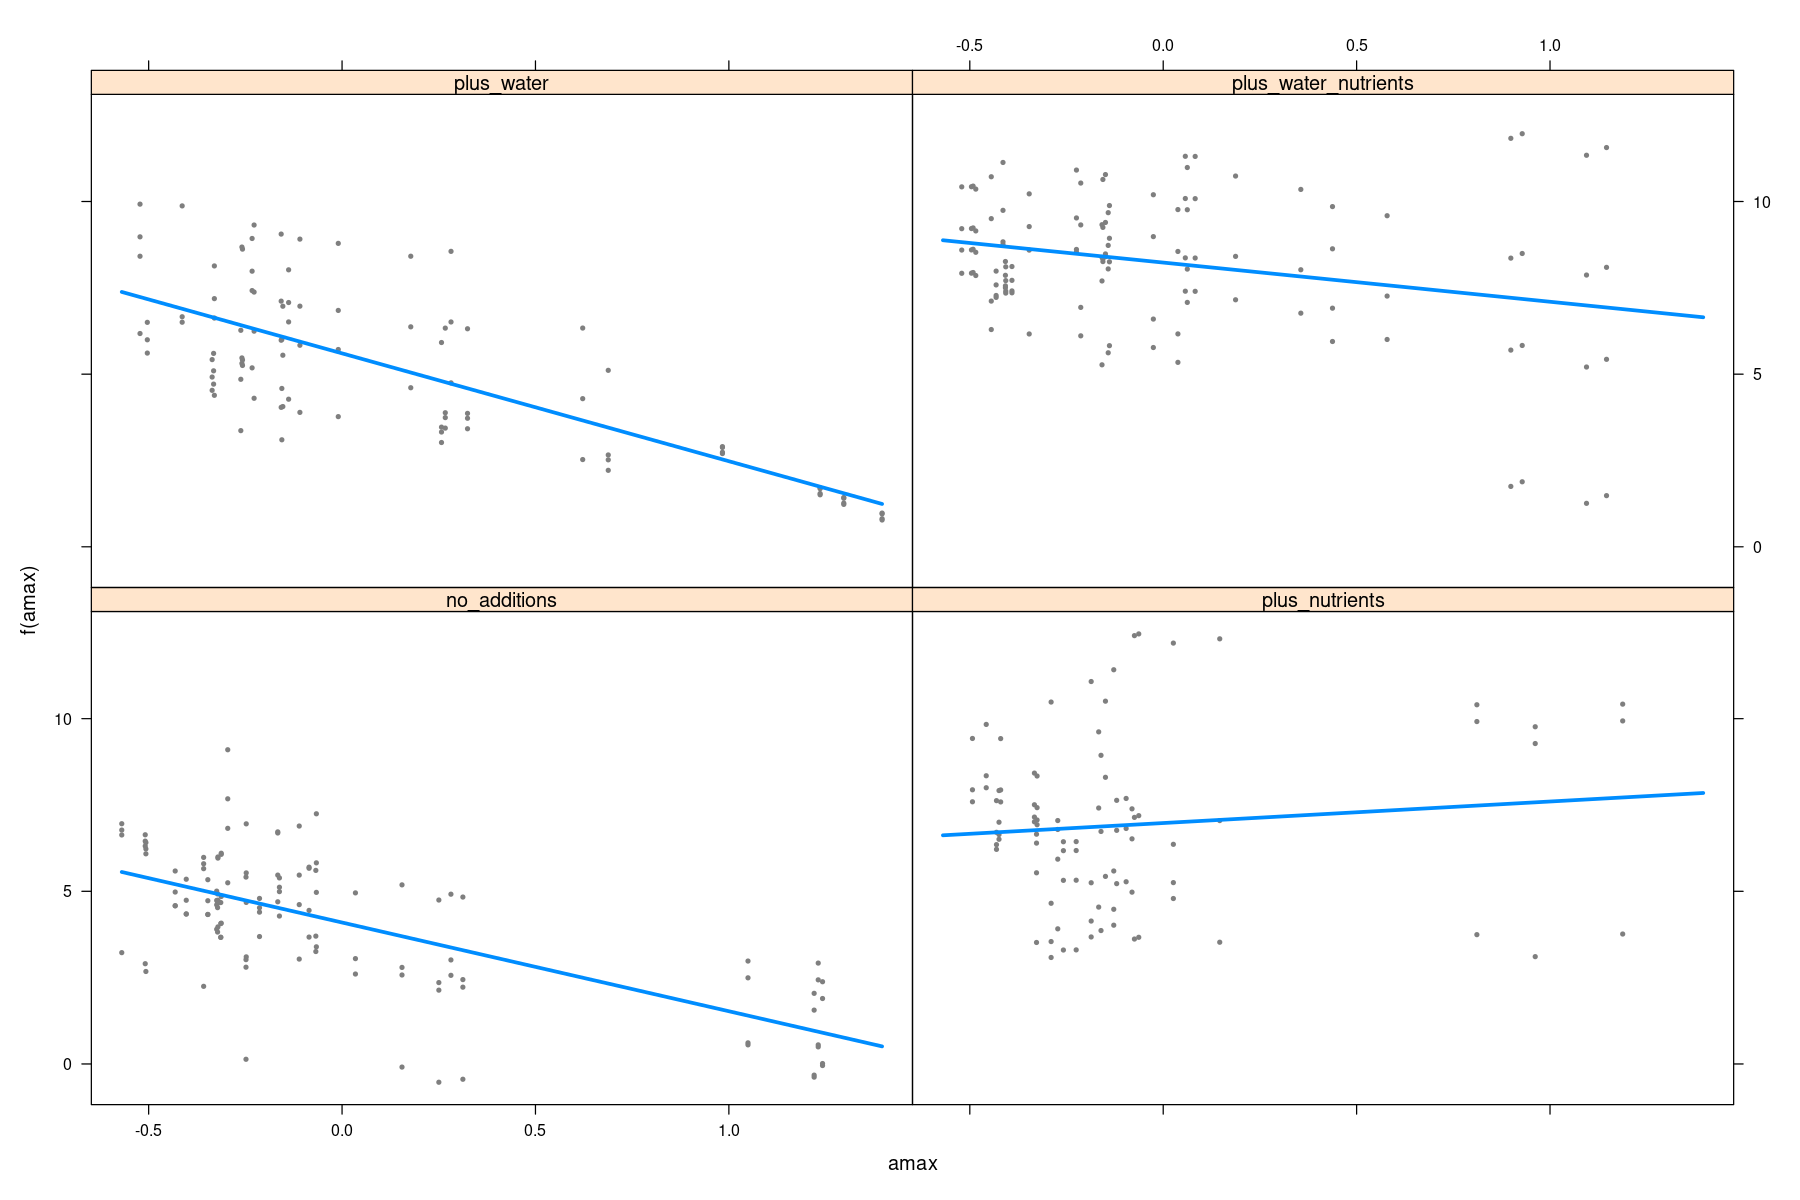

In [498]:
visreg(model_pc_total_biomass, "amax", by = "treatment")

#### gs

In [510]:
emtrends(model_pc_total_biomass,
        pairwise ~ treatment,
        var = "gs")$contrast %>%
        kable()



|contrast                              |   estimate|        SE|       df|  lower.CL|  upper.CL|    t.ratio|   p.value|
|:-------------------------------------|----------:|---------:|--------:|---------:|---------:|----------:|---------:|
|no_additions - plus_nutrients         | -0.8551437| 1.4243998| 403.6094| -4.529762| 2.8194741| -0.6003537| 0.9319097|
|no_additions - plus_water             | -2.7592296| 1.2332808| 404.6503| -5.940771| 0.4223119| -2.2373084| 0.1150143|
|no_additions - plus_water_nutrients   | -1.5165435| 0.8761112| 405.5070| -3.776661| 0.7435740| -1.7309943| 0.3089198|
|plus_nutrients - plus_water           | -1.9040859| 1.4539168| 404.3461| -5.654822| 1.8466503| -1.3096251| 0.5573048|
|plus_nutrients - plus_water_nutrients | -0.6613998| 1.2983576| 403.7976| -4.010852| 2.6880522| -0.5094127| 0.9568278|
|plus_water - plus_water_nutrients     |  1.2426860| 0.9758562| 404.7701| -1.274764| 3.7601363|  1.2734315| 0.5804084|

#### sla

In [511]:
emtrends(model_pc_total_biomass,
        pairwise ~ treatment,
        var = "sla")$contrast %>%
        kable()



|contrast                              |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|no_additions - plus_nutrients         |  0.4112538| 0.6614408| 406.2848| -1.2950616|  2.1175693|  0.6217546| 0.9250864|
|no_additions - plus_water             |  2.2483794| 0.8176415| 405.9782|  0.1391071|  4.3576517|  2.7498351| 0.0315264|
|no_additions - plus_water_nutrients   |  0.0332050| 0.5840141| 407.5000| -1.4733547|  1.5397646|  0.0568564| 0.9999339|
|plus_nutrients - plus_water           |  1.8371255| 0.8037201| 405.4036| -0.2362457|  3.9104968|  2.2857778| 0.1030282|
|plus_nutrients - plus_water_nutrients | -0.3780489| 0.6146901| 405.3650| -1.9637768|  1.2076790| -0.6150235| 0.9272720|
|plus_water - plus_water_nutrients     | -2.2151744| 0.7580466| 403.4598| -4.1707600| -0.2595889| -2.9222142| 0.0191592|

In [512]:
emtrends(model_pc_total_biomass,
        pairwise ~ treatment,
        var = "sla")$emtrends %>%
        kable()



|treatment            |  sla.trend|        SE|       df|  lower.CL|   upper.CL|
|:--------------------|----------:|---------:|--------:|---------:|----------:|
|no_additions         | -0.3512734| 0.5133368| 408.9978| -1.360381|  0.6578343|
|plus_nutrients       | -0.7625272| 0.6166866| 408.9823| -1.974798|  0.4497439|
|plus_water           | -2.5996527| 0.7901996| 408.9685| -4.153012| -1.0462930|
|plus_water_nutrients | -0.3844783| 0.5385676| 404.3300| -1.443221|  0.6742639|

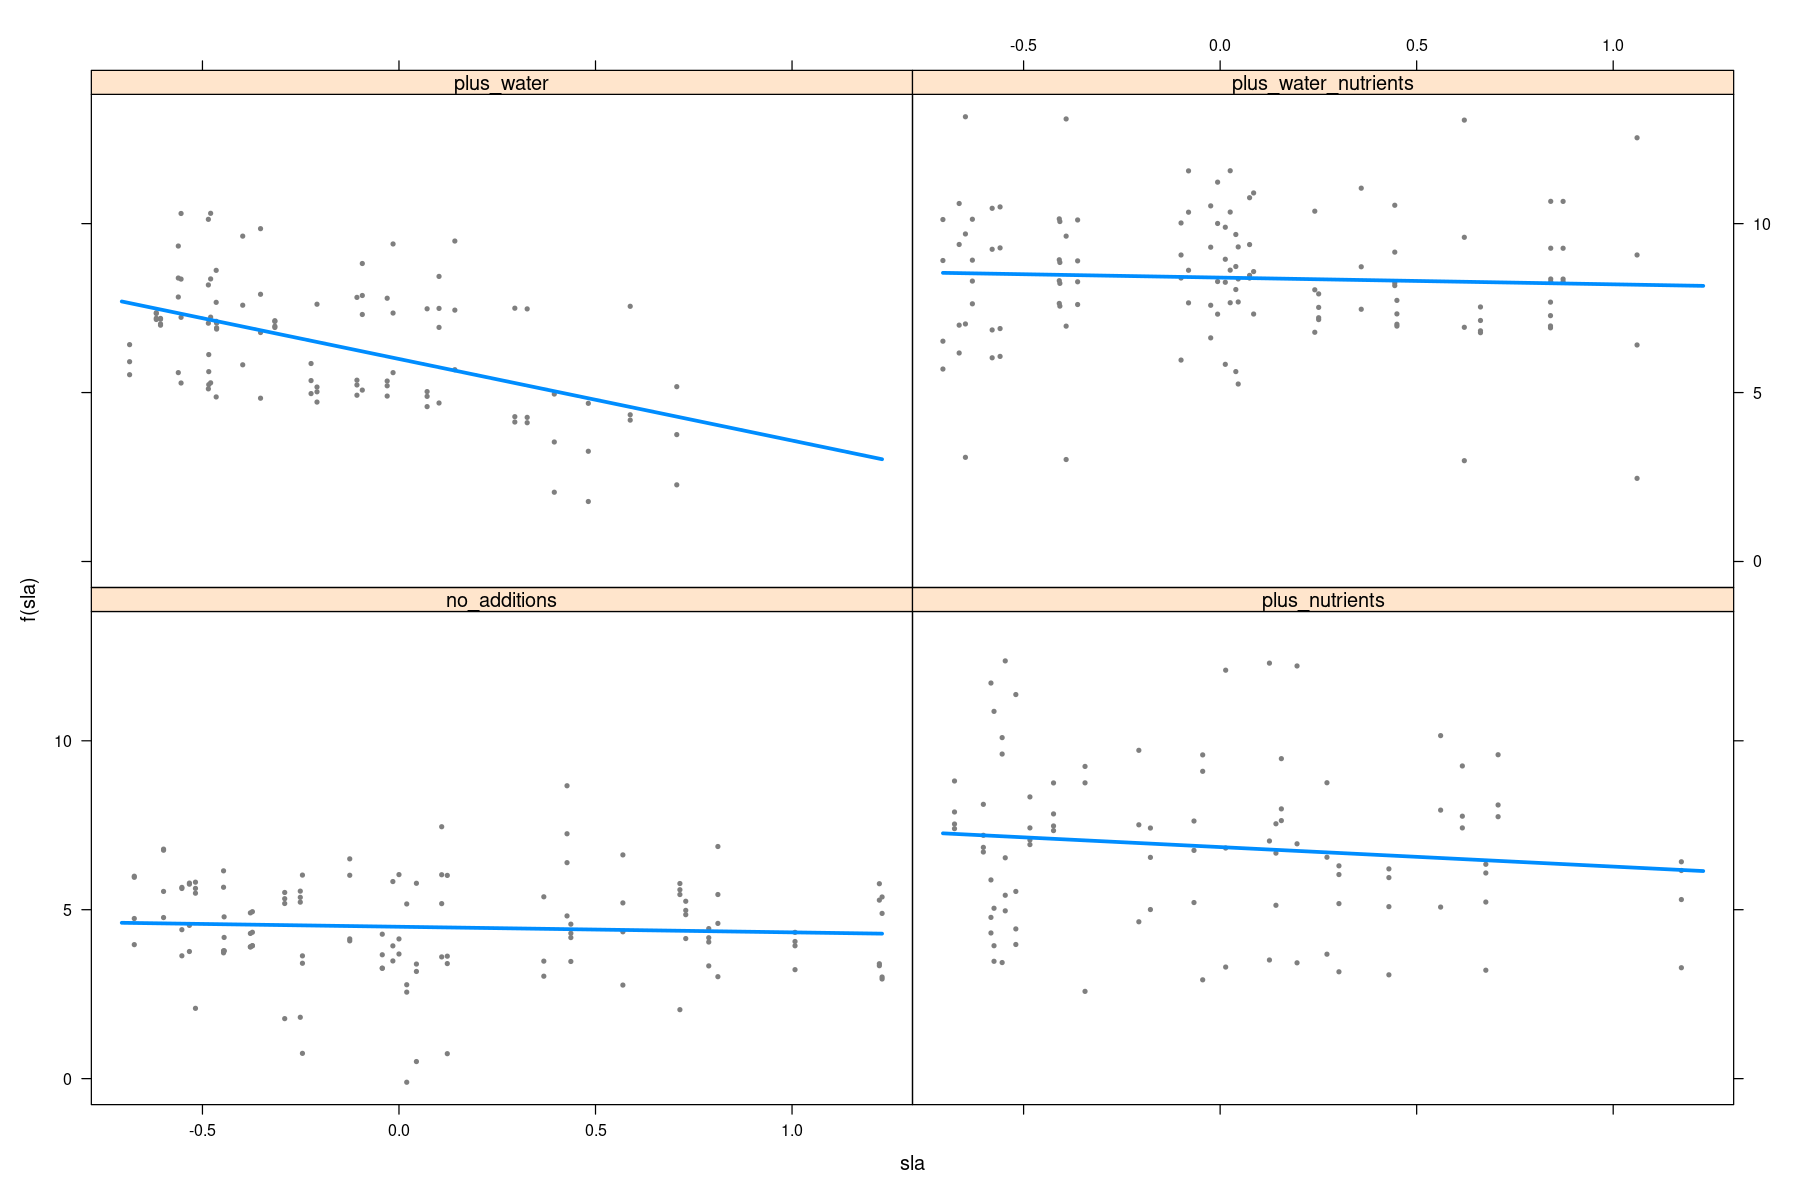

In [513]:
visreg(model_pc_total_biomass, "sla", by = "treatment")

#### PNUE

In [514]:
emtrends(model_pc_total_biomass,
        pairwise ~ treatment,
        var = "pnue")$contrast %>%
        kable()



|contrast                              |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|no_additions - plus_nutrients         |  2.8077891| 0.9621796| 406.8157|  0.3256727|  5.2899055|  2.9181549| 0.0193846|
|no_additions - plus_water             |  0.6009377| 0.7843785| 407.8339| -1.4224877|  2.6243632|  0.7661323| 0.8696623|
|no_additions - plus_water_nutrients   | -0.0954730| 0.8457109| 408.3431| -2.2771034|  2.0861573| -0.1128909| 0.9994848|
|plus_nutrients - plus_water           | -2.2068514| 0.9467588| 408.8820| -4.6491358|  0.2354330| -2.3309543| 0.0927519|
|plus_nutrients - plus_water_nutrients | -2.9032621| 0.9664852| 407.2692| -5.3964741| -0.4100502| -3.0039385| 0.0149595|
|plus_water - plus_water_nutrients     | -0.6964108| 0.7204126| 404.4426| -2.5548906|  1.1620691| -0.9666832| 0.7684757|

In [515]:
emtrends(model_pc_total_biomass,
        pairwise ~ treatment,
        var = "pnue")$emtrends %>%
        kable()



|treatment            | pnue.trend|        SE|       df|   lower.CL|   upper.CL|
|:--------------------|----------:|---------:|--------:|----------:|----------:|
|no_additions         |  0.9372171| 0.6620249| 397.7972| -0.3642877|  2.2387219|
|plus_nutrients       | -1.8705720| 0.8737145| 408.0175| -3.5881157| -0.1530283|
|plus_water           |  0.3362794| 0.6188580| 396.0436| -0.8803782|  1.5529369|
|plus_water_nutrients |  1.0326901| 0.7178114| 406.8553| -0.3783921|  2.4437723|

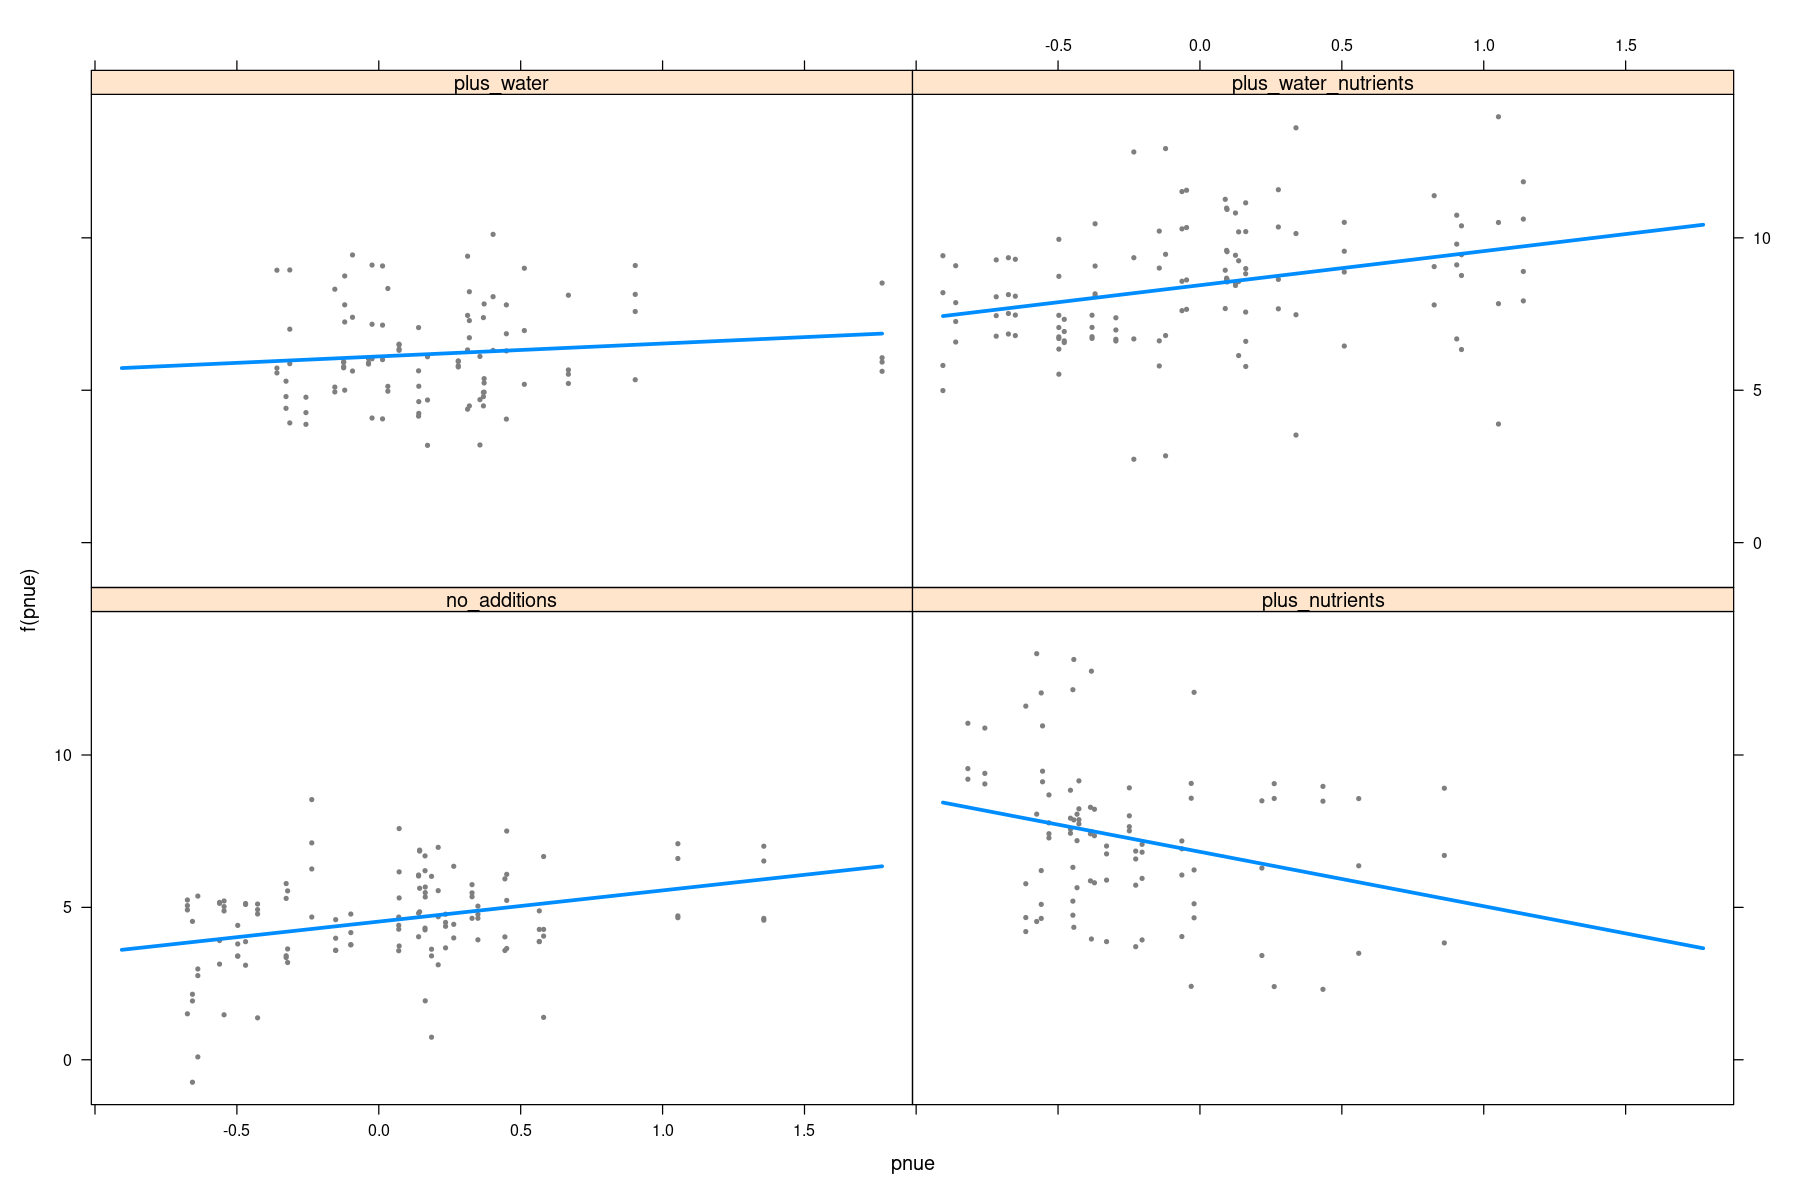

In [516]:

visreg(model_pc_total_biomass, "pnue", by = "treatment")

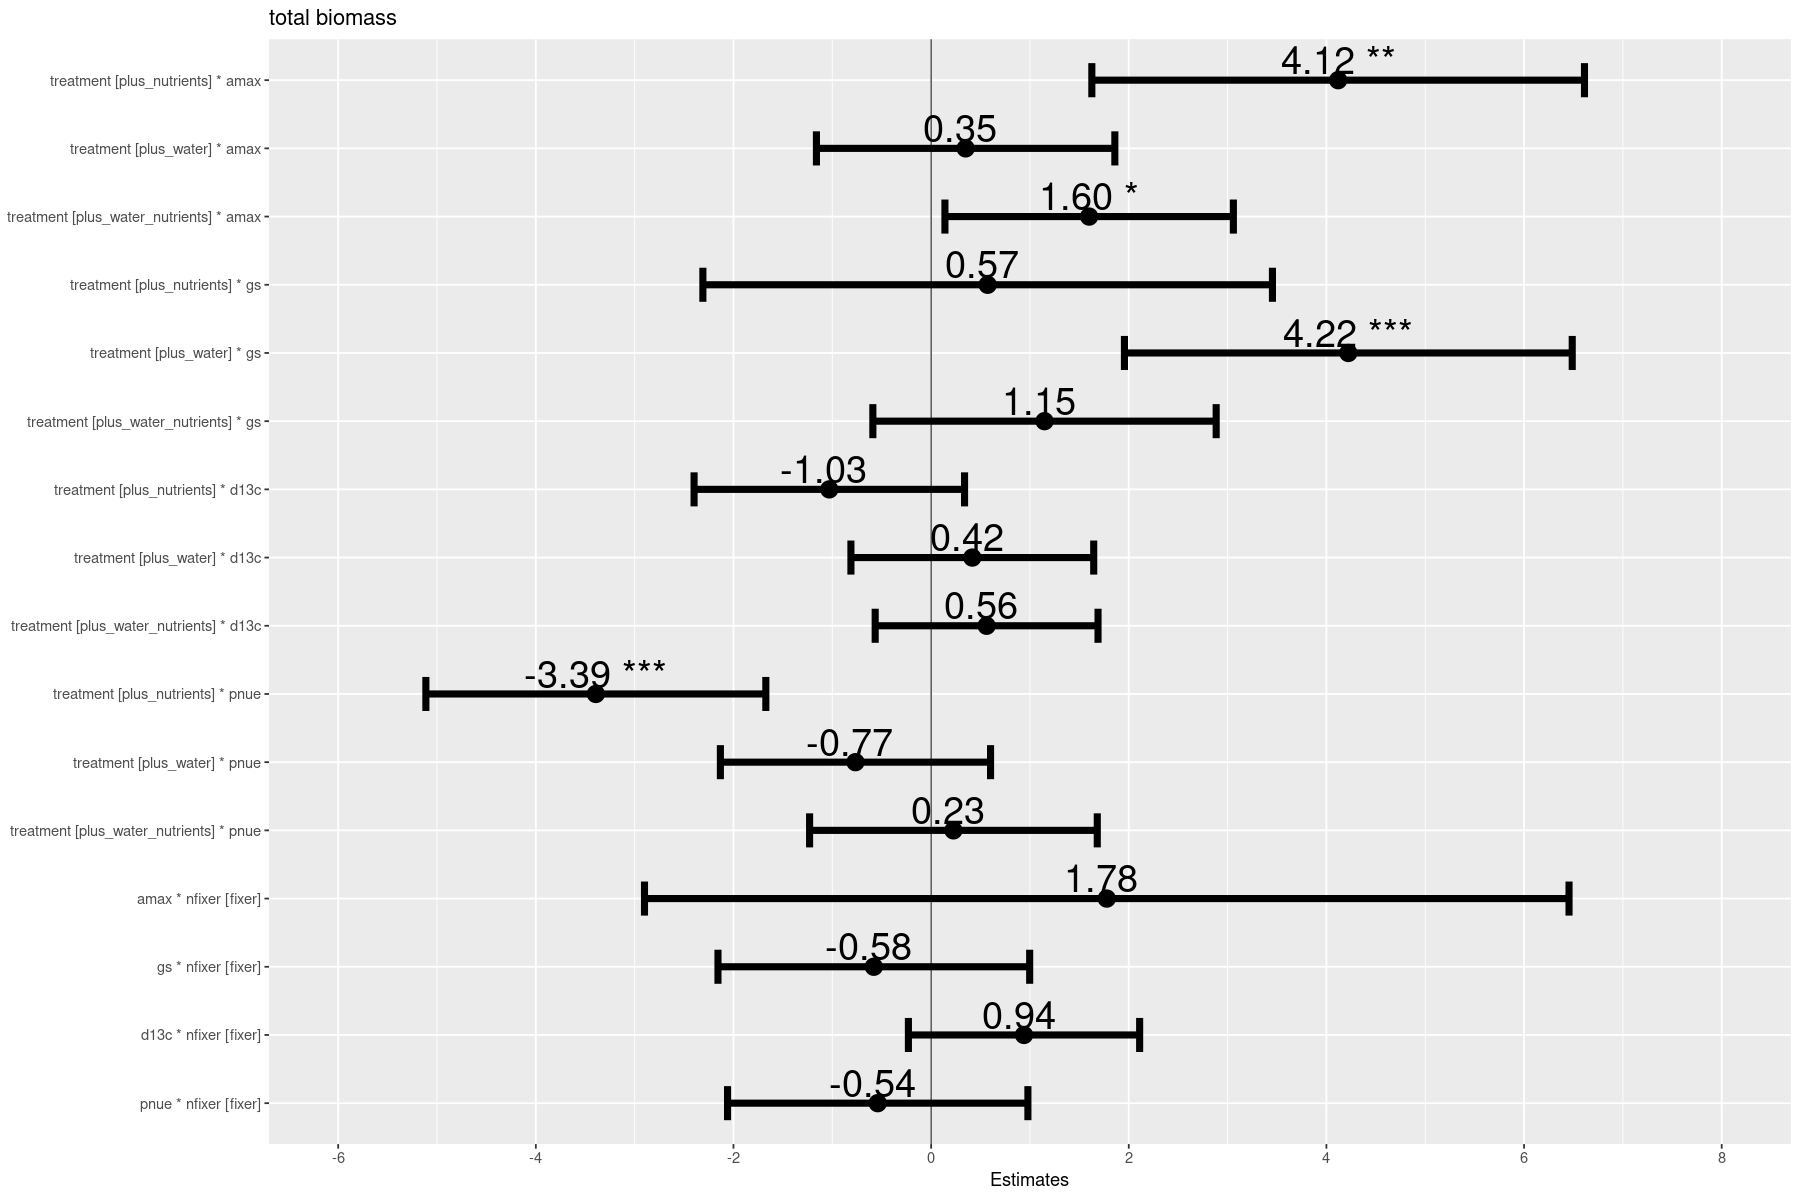

In [100]:
plot_model(model_pc_total_biomass, show.values = TRUE,

                        rm.terms = c("treatmentplus_nutrients","treatmentplus_water",
                                    "treatmentplus_water_nutrients",
                                    "amax", "gs", "d13c", "pnue", "init_height",
                                    "nfixerfixer"
                                    #, "amax:nfixerfixer",
                                    #"gs:nfixerfixer", "d13c:nfixerfixer",
                                    #"pnue:nfixerfixer"
                                    ),
                        colors = "black",
                        value.offset = .3,
                        value.size = 8,
                        dot.size = 4.5,
                        line.size = 2,
                        vline.color = "black",
                        width = 0.5,
                        show.p = TRUE,
                        )

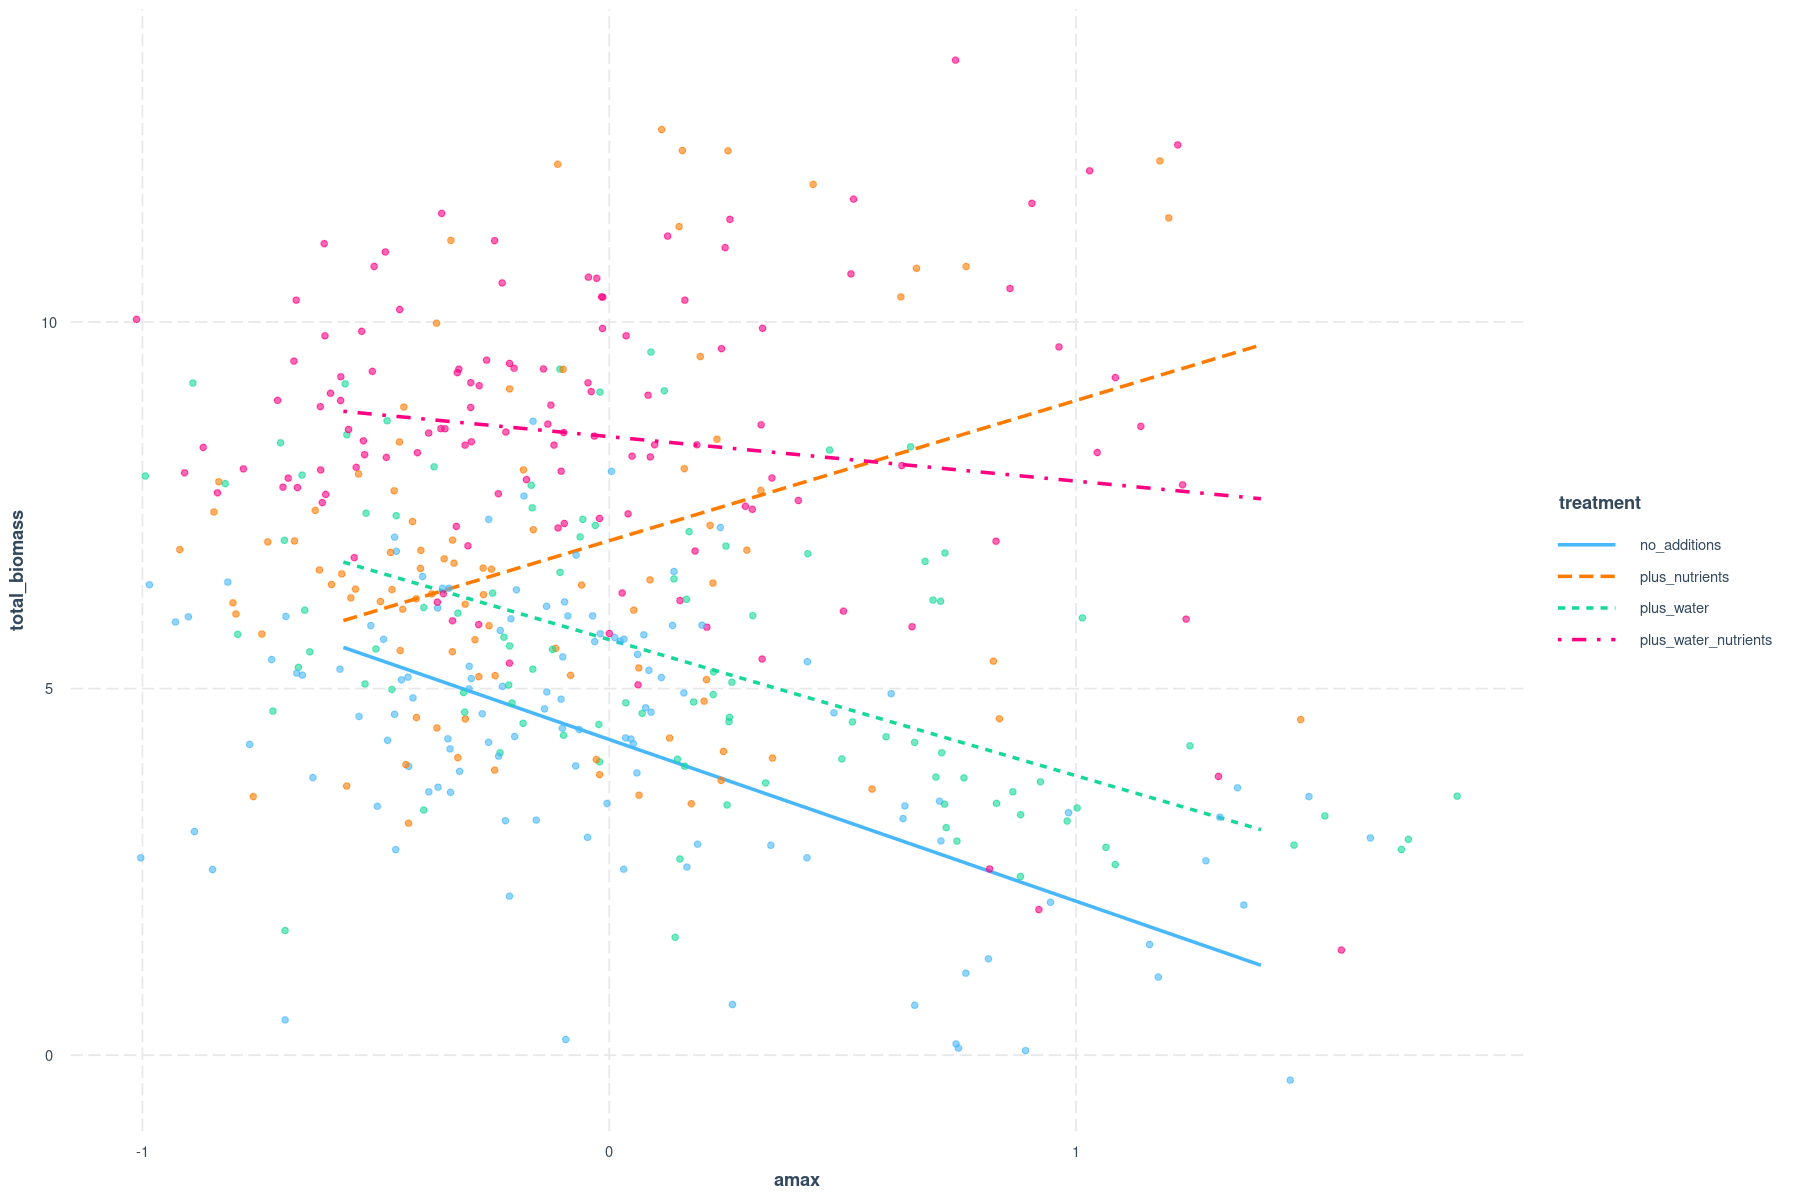

In [299]:
library(interactions)
interact_plot(model_pc_total_biomass, pred = "amax", modx = treatment, plot.points = TRUE, jitter = 0.5, partial.residuals = TRUE)

#### Bootstrap

In [180]:
## Bootstrap
source("./R/function_for_inference_bootstrap.R")

In [181]:
if (file.exists("./processed_data/bootstrap_ci_total_biomass.RData")) {

    print("The bootstrap exists")

    bootstrap_ci_total_biomass <- readRDS("./processed_data/bootstrap_ci_total_biomass.RData")

    print("File read")

} else {

    print("The bootstrap does not exist, Creating bootstrap")

    bootstrap_ci_total_biomass <-
        bootstrap_model_ci_df(model = model_pc_total_biomass,
                              category = "all",

                              iter = 9999)

    saveRDS(bootstrap_ci_total_biomass,
            file = "./processed_data/bootstrap_ci_total_biomass.RData")

}

[1] "The bootstrap does not exist, Creating bootstrap"


→ Available options for category are norm, basic, perc or all



Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 24 rows [1, 2, 3, 4, 5, 6, 7, 8, 25, 26, 27, 28, 29, 30, 31, 32, 49, 50, 51, 52, ...].”


In [185]:
colmn <- paste0("col_", 1:2)

#data_total_biomass_plot <-

        bootstrap_ci_total_biomass  %>%

            unite("treat_trait", col_1, col_2, sep = "-", remove = F) %>%
            mutate(across(where(is.character), as.factor)) %>%
            filter(type == "norm")

treat_trait,col_1,col_2,estimate,lower,upper,type,level,response_var,significance
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<lgl>
amax-fixer,amax,fixer,1.77737676,-2.912953313,6.4460850,norm,0.95,total_biomass,FALSE
amax-NA,amax,NA,-2.20592338,-6.067320890,1.6618204,norm,0.95,total_biomass,FALSE
d13c-fixer,d13c,fixer,0.94011474,-0.202987158,2.1047399,norm,0.95,total_biomass,FALSE
d13c-NA,d13c,NA,0.08000617,-0.794143385,0.9600683,norm,0.95,total_biomass,FALSE
gs-fixer,gs,fixer,-0.57984461,-2.165758546,1.0020286,norm,0.95,total_biomass,FALSE
gs-NA,gs,NA,-1.47873525,-2.846566789,-0.1271303,norm,0.95,total_biomass,TRUE
nfixerfixer-NA,nfixerfixer,NA,4.47546680,-0.006349944,8.9267938,norm,0.95,total_biomass,FALSE
plus_nutrients-amax,plus_nutrients,amax,4.11888451,1.598277993,6.6018669,norm,0.95,total_biomass,TRUE
plus_nutrients-d13c,plus_nutrients,d13c,-1.03015903,-2.386627757,0.3306680,norm,0.95,total_biomass,FALSE


### RGR 

In [47]:
Anova(model_pc_rgr, type = "III", test.statistic = c("F"))

,F,Df,Df.res,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),18.1702563,1,7.65737,3.041206e-03
treatment,35.3021286,3,404.26341,2.774815e-20
amax,1.3706176,1,406.70522,2.423913e-01
gs,3.8520922,1,403.71337,5.037030e-02
d13c,0.1331503,1,405.05248,7.153783e-01
pnue,1.0837630,1,405.08150,2.984782e-01
nfixer,5.5001171,1,6.63216,5.342763e-02
init_height,109.2871253,1,405.23449,8.308489e-23
treatment:amax,3.5452868,3,404.91523,1.468311e-02


#### Amax

In [48]:
emtrends(model_pc_rgr,
        pairwise ~ amax*treatment,
        var = "amax")$contrast %>%
        kable()



|contrast                                                                                    |   estimate|        SE|       df|   lower.CL|  upper.CL|   t.ratio|   p.value|
|:-------------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|---------:|---------:|---------:|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_nutrients)         | -0.0008931| 0.0004534| 405.0045| -0.0020627| 0.0002765| -1.969886| 0.2011501|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_water)             |  0.0002796| 0.0002730| 403.9750| -0.0004246| 0.0009839|  1.024294| 0.7353055|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_water_nutrients)   | -0.0003793| 0.0002663| 406.4248| -0.0010663| 0.0003076| -1.424509| 0.4847331|
|(amax-0.00277714125138734 plus_nutrients) - (amax-0.00277714125138734 plus_water)           |  0.0011727| 0.0004497| 404.5281|  0.00

#### gs

In [389]:
emtrends(model_pc_rgr,
        pairwise ~ gs*treatment,
        var = "gs")$contrast %>%
        kable()

ERROR: Error in emtrends(model_pc_rgr, pairwise ~ gs * treatment, var = "gs"): object 'model_pc_rgr' not found


#### d13c

In [50]:
emtrends(model_pc_rgr,
        pairwise ~ d13c*treatment,
        var = "d13c")$contrast %>%
        kable()



|contrast                                                                                  |   estimate|        SE|       df|   lower.CL|  upper.CL|    t.ratio|   p.value|
|:-----------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|---------:|----------:|---------:|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_nutrients)         | -0.0002024| 0.0002467| 404.3998| -0.0008389| 0.0004340| -0.8204919| 0.8447707|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_water)             | -0.0004663| 0.0002241| 404.6557| -0.0010444| 0.0001117| -2.0810759| 0.1610311|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_water_nutrients)   | -0.0001747| 0.0002000| 404.2958| -0.0006906| 0.0003412| -0.8735710| 0.8185436|
|(d13c-0.0311804624367142 plus_nutrients) - (d13c-0.0311804624367142 plus_water)           | -0.0002639| 0.0002522| 403.0913| -0.0009146| 

#### PNUE

In [52]:
emtrends(model_pc_rgr,
        pairwise ~ pnue*treatment,
        var = "pnue")$contrast %>%
        kable()



|contrast                                                                              |   estimate|        SE|       df|   lower.CL|  upper.CL|    t.ratio|   p.value|
|:-------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|---------:|----------:|---------:|
|pnue0.00179582118045257 no_additions - pnue0.00179582118045257 plus_nutrients         |  0.0004444| 0.0003141| 404.2186| -0.0003659| 0.0012546|  1.4147538| 0.4908200|
|pnue0.00179582118045257 no_additions - pnue0.00179582118045257 plus_water             |  0.0003025| 0.0002457| 405.9219| -0.0003313| 0.0009363|  1.2312018| 0.6073531|
|pnue0.00179582118045257 no_additions - pnue0.00179582118045257 plus_water_nutrients   |  0.0000620| 0.0002616| 403.5922| -0.0006129| 0.0007369|  0.2370277| 0.9953085|
|pnue0.00179582118045257 plus_nutrients - pnue0.00179582118045257 plus_water           | -0.0001419| 0.0003334| 405.2429| -0.0010021| 0.0007183| -0.4254710| 0

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


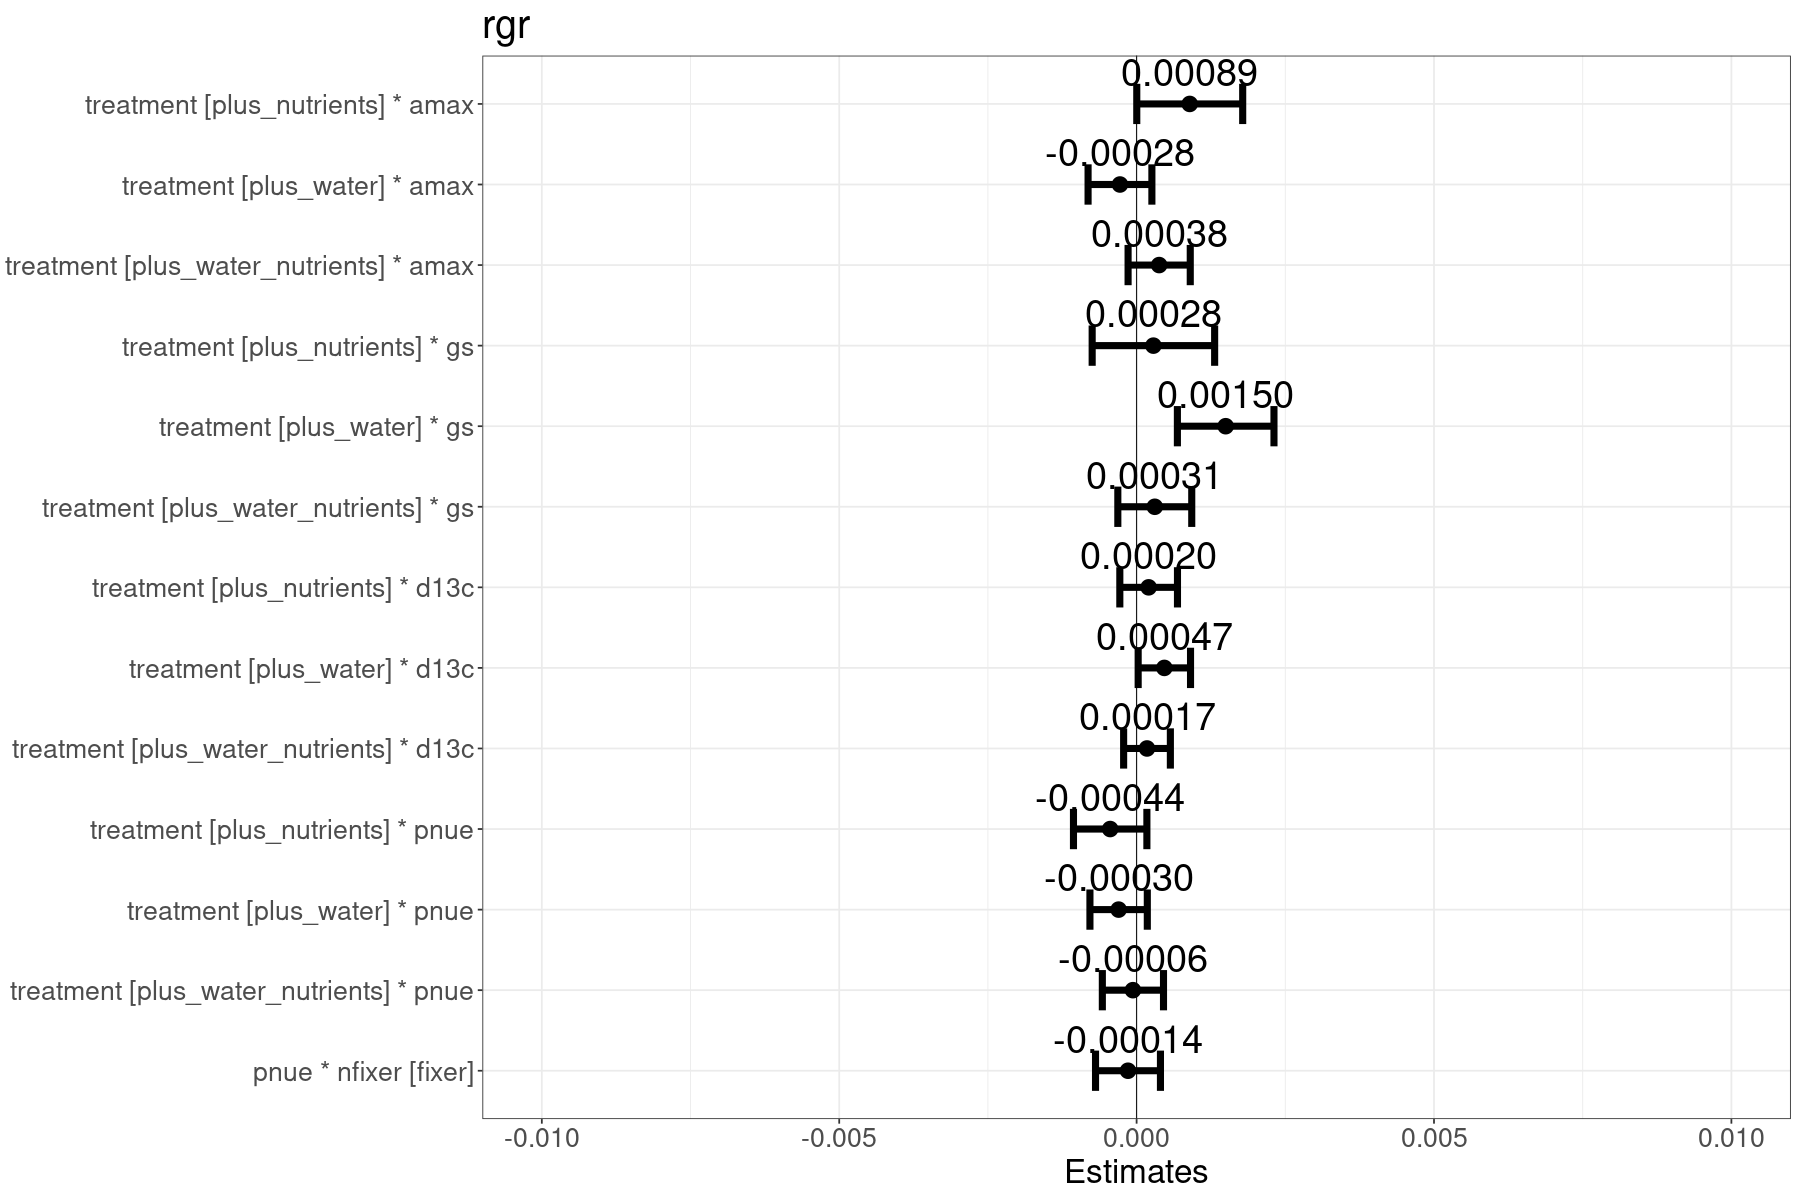

In [53]:
plot_model(model_pc_rgr, show.values = TRUE,

                        rm.terms = c("treatmentplus_nutrients","treatmentplus_water",
                                    "treatmentplus_water_nutrients",
                                    "amax", "gs", "d13c", "pnue", "init_height",
                                    "nfixerfixer", "amax:nfixerfixer",
                                    "gs:nfixerfixer", "d13c:nfixerfixer",
                                    "pnue:nfixerfixer"),
                        colors = "black",
                        value.offset = .4,
                        value.size = 8,
                        dot.size = 4,
                        line.size = 2,
                        vline.color = "black",
                        width = 0.5,
                        show.p = FALSE,
                        digits = 5

                        ) +
                        theme_bw() +
                        theme(text = element_text(size = 20)) +
                        ylim(-0.01,0.01)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


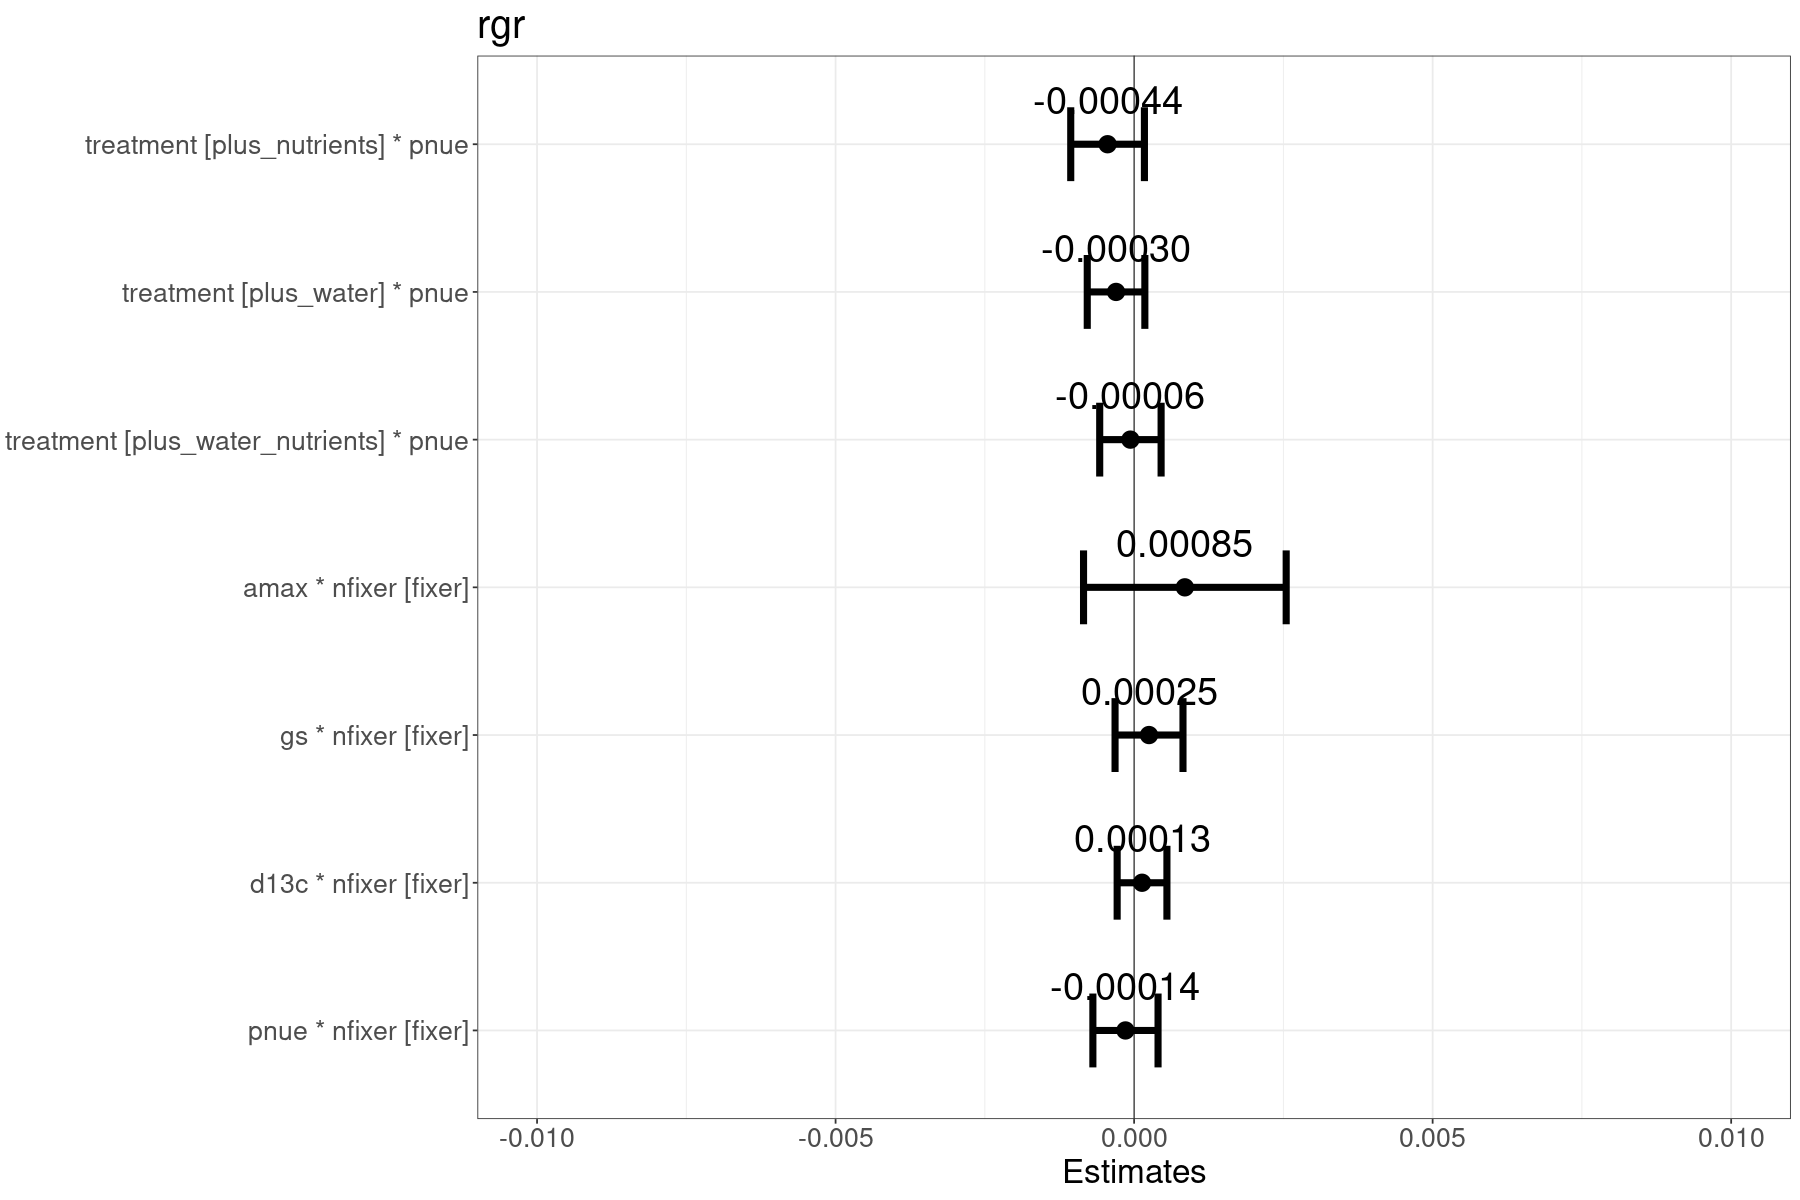

In [54]:
plot_model(model_pc_rgr, show.values = TRUE,

                        rm.terms = c("treatmentplus_nutrients",
                                    "treatmentplus_water",
                                    "treatmentplus_water_nutrients",
                                    "amax", "gs", "d13c",
                                    "pnue", "init_height",

                                    "nfixerfixer",

                                     "treatmentplus_nutrients:amax",
                                     "treatmentplus_water:amax",
                                     "treatmentplus_water_nutrients:amax",



                                     "treatmentplus_nutrients:gs",
                                     "treatmentplus_water:gs",
                                     "treatmentplus_water_nutrients:gs",

                                     "treatmentplus_nutrients:d13c",
                                     "treatmentplus_water:d13c",
                                     "treatmentplus_water_nutrients:d13c",

                                     "treatmentplus_nutrients:pnue",
                                     "treatmentplus_water:pnue",
                                     "treatmentplus_water_nutrients:pnue"


                        ),
                        colors = "black",
                        value.offset = .3,
                        value.size = 8,
                        dot.size = 4.5,
                        line.size = 2,
                        vline.color = "black",
                        width = 0.5,
                        show.p = FALSE,
                        digits = 5

                        ) +
                        theme_bw() +
                        theme(text = element_text(size = 20)) +
                        ylim(-0.01,0.01)

### Root to shoot ratio 

In [55]:
Anova(model_pc_root_shoot, type = "III", test.statistic = c("F"))

,F,Df,Df.res,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),13.70814749,1,7.019865,7.591816e-03
treatment,2.88310655,3,403.834236,3.561265e-02
amax,0.01115820,1,405.512043,9.159262e-01
gs,1.67443031,1,403.450617,1.964064e-01
d13c,0.91130179,1,404.351320,3.403396e-01
pnue,0.23526538,1,404.348971,6.279095e-01
nfixer,0.21452813,1,6.404849,6.585644e-01
init_height,0.30015179,1,408.900569,5.840862e-01
treatment:amax,13.60105767,3,404.290819,1.804196e-08


#### Amax

In [56]:
emtrends(model_pc_root_shoot,
        pairwise ~ amax*treatment,
        var = "amax")$contrast %>%
        kable()



|contrast                                                                                    |   estimate|        SE|       df|   lower.CL|   upper.CL|   t.ratio|   p.value|
|:-------------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|----------:|---------:|---------:|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_nutrients)         | -0.4664135| 0.0864436| 404.3256| -0.6894161| -0.2434109| -5.395581| 0.0000007|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_water)             | -0.2567512| 0.0520450| 403.6198| -0.3910150| -0.1224874| -4.933258| 0.0000070|
|(amax-0.00277714125138734 no_additions) - (amax-0.00277714125138734 plus_water_nutrients)   | -0.1833433| 0.0507838| 405.3540| -0.3143512| -0.0523354| -3.610273| 0.0019463|
|(amax-0.00277714125138734 plus_nutrients) - (amax-0.00277714125138734 plus_water)           |  0.2096623| 0.0857324| 404.0083| 

#### gs

In [433]:
emtrends(model_pc_root_shoot,
        pairwise ~ gs:treatment,
        var = "gs")$contrast %>%
        kable()

ERROR: Error in emtrends(model_pc_root_shoot, pairwise ~ gs:treatment, var = "gs"): object 'model_pc_root_shoot' not found


#### d13c

In [58]:
emtrends(model_pc_root_shoot,
        pairwise ~ d13c*treatment,
        var = "d13c")$contrast %>%
        kable()



|contrast                                                                                  |   estimate|        SE|       df|   lower.CL|   upper.CL|   t.ratio|   p.value|
|:-----------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|----------:|---------:|---------:|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_nutrients)         |  0.1770022| 0.0470366| 403.9193|  0.0556592|  0.2983452|  3.763073| 0.0011015|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_water)             |  0.0879497| 0.0427247| 404.0994| -0.0222694|  0.1981688|  2.058521| 0.1686612|
|(d13c-0.0311804624367142 no_additions) - (d13c-0.0311804624367142 plus_water_nutrients)   |  0.0093232| 0.0381254| 403.8519| -0.0890311|  0.1076775|  0.244540| 0.9948551|
|(d13c-0.0311804624367142 plus_nutrients) - (d13c-0.0311804624367142 plus_water)           | -0.0890525| 0.0480842| 403.0563| -0.2130991| 

#### PNUE

In [59]:
emtrends(model_pc_root_shoot,
        pairwise ~ pnue*treatment,
        var = "pnue")$contrast %>%
        kable()



|contrast                                                                              |   estimate|        SE|       df|   lower.CL|   upper.CL|    t.ratio|   p.value|
|:-------------------------------------------------------------------------------------|----------:|---------:|--------:|----------:|----------:|----------:|---------:|
|pnue0.00179582118045257 no_additions - pnue0.00179582118045257 plus_nutrients         |  0.1969485| 0.0598803| 403.7773|  0.0424715|  0.3514254|  3.2890349| 0.0059993|
|pnue0.00179582118045257 no_additions - pnue0.00179582118045257 plus_water             |  0.0083926| 0.0468496| 404.9865| -0.1124666|  0.1292518|  0.1791397| 0.9979563|
|pnue0.00179582118045257 no_additions - pnue0.00179582118045257 plus_water_nutrients   |  0.0174529| 0.0498758| 403.3815| -0.1112152|  0.1461210|  0.3499275| 0.9852749|
|pnue0.00179582118045257 plus_nutrients - pnue0.00179582118045257 plus_water           | -0.1885559| 0.0635804| 404.5045| -0.3525769| -0.0245348| -2.9656

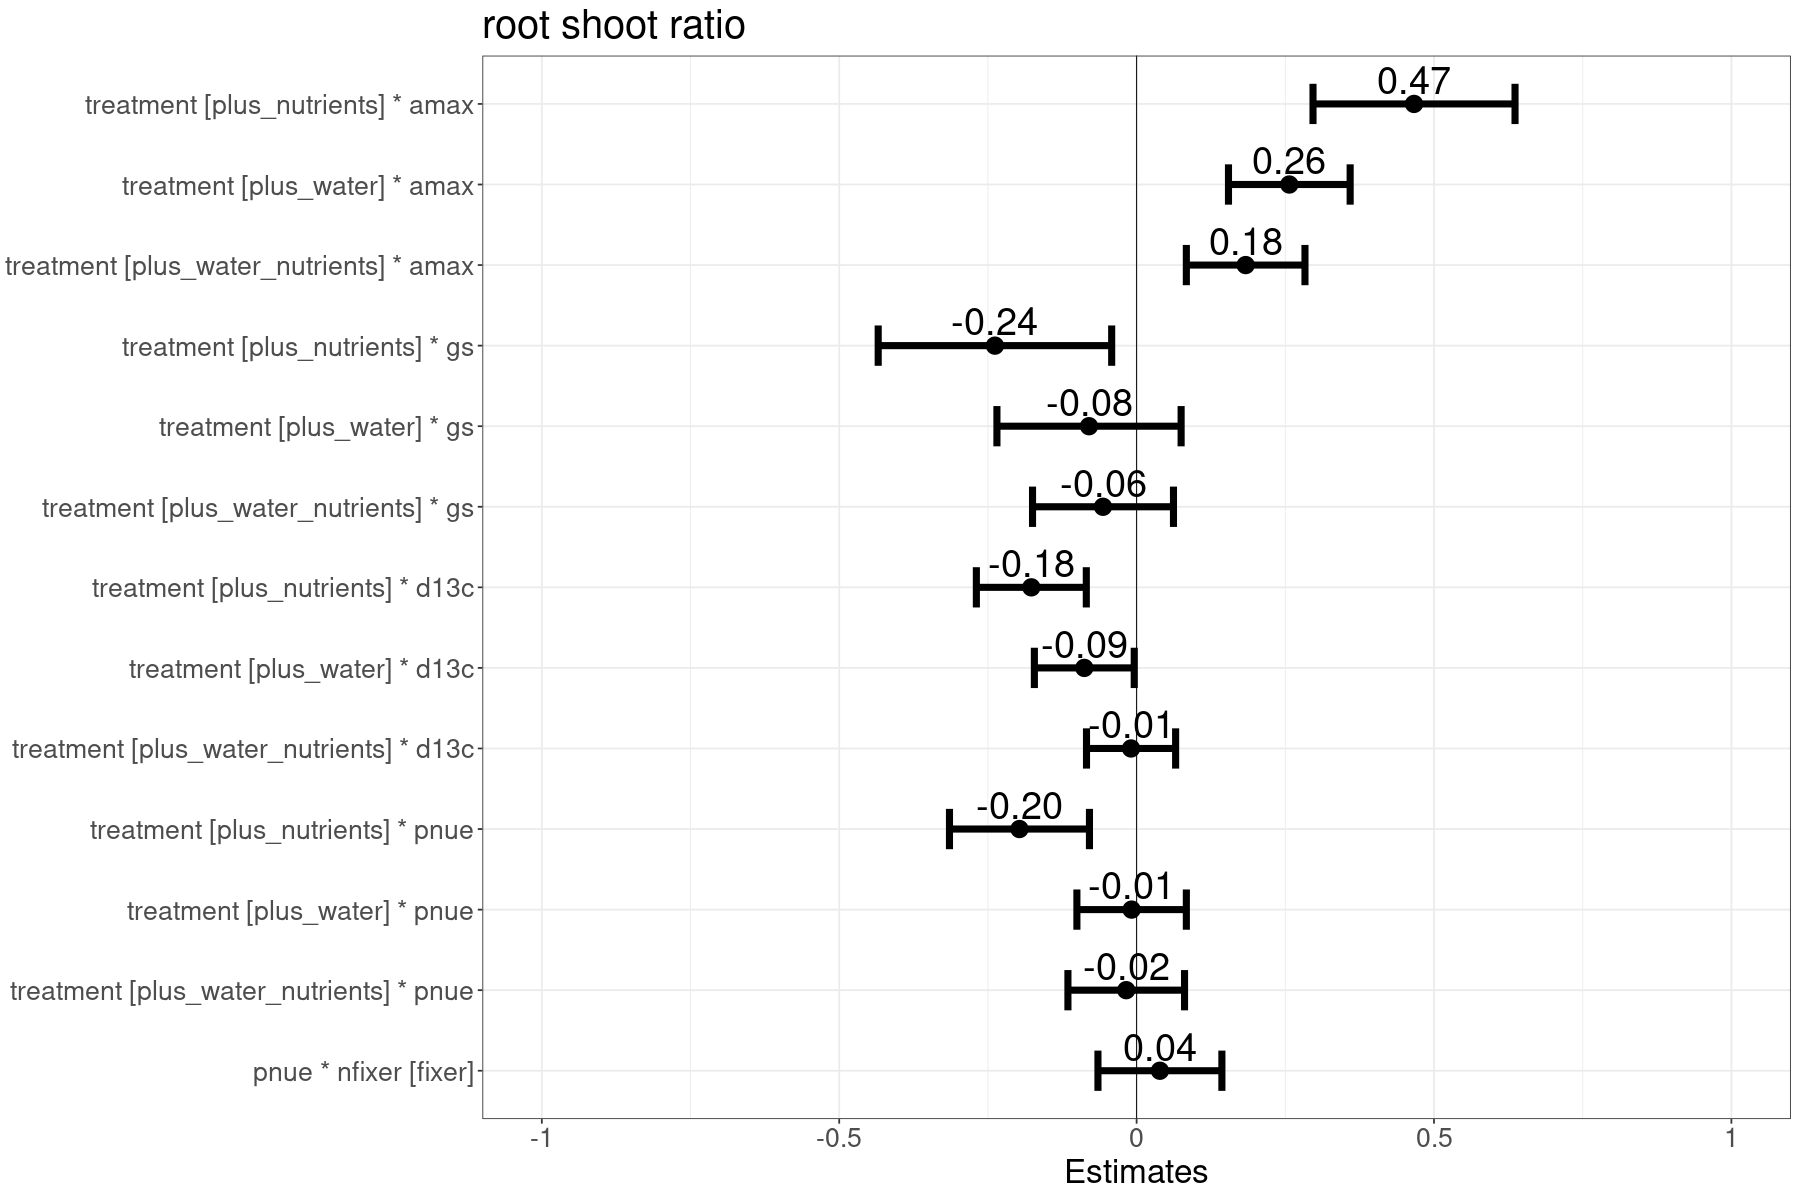

In [60]:
plot_model(model_pc_root_shoot, show.values = TRUE,

                        rm.terms = c("treatmentplus_nutrients","treatmentplus_water",
                                    "treatmentplus_water_nutrients",
                                    "amax", "gs", "d13c", "pnue", "init_height",
                                    "nfixerfixer", "amax:nfixerfixer",
                                    "gs:nfixerfixer", "d13c:nfixerfixer",
                                    "pnue:nfixerfixer"
                                    ),
                        colors = "black",
                        value.offset = .3,
                        value.size = 8,
                        dot.size = 4.5,
                        line.size = 2,
                        vline.color = "black",
                        width = 0.5,
                        show.p = FALSE,

                        ) +
                        theme_bw() +
                        theme(text = element_text(size = 20))

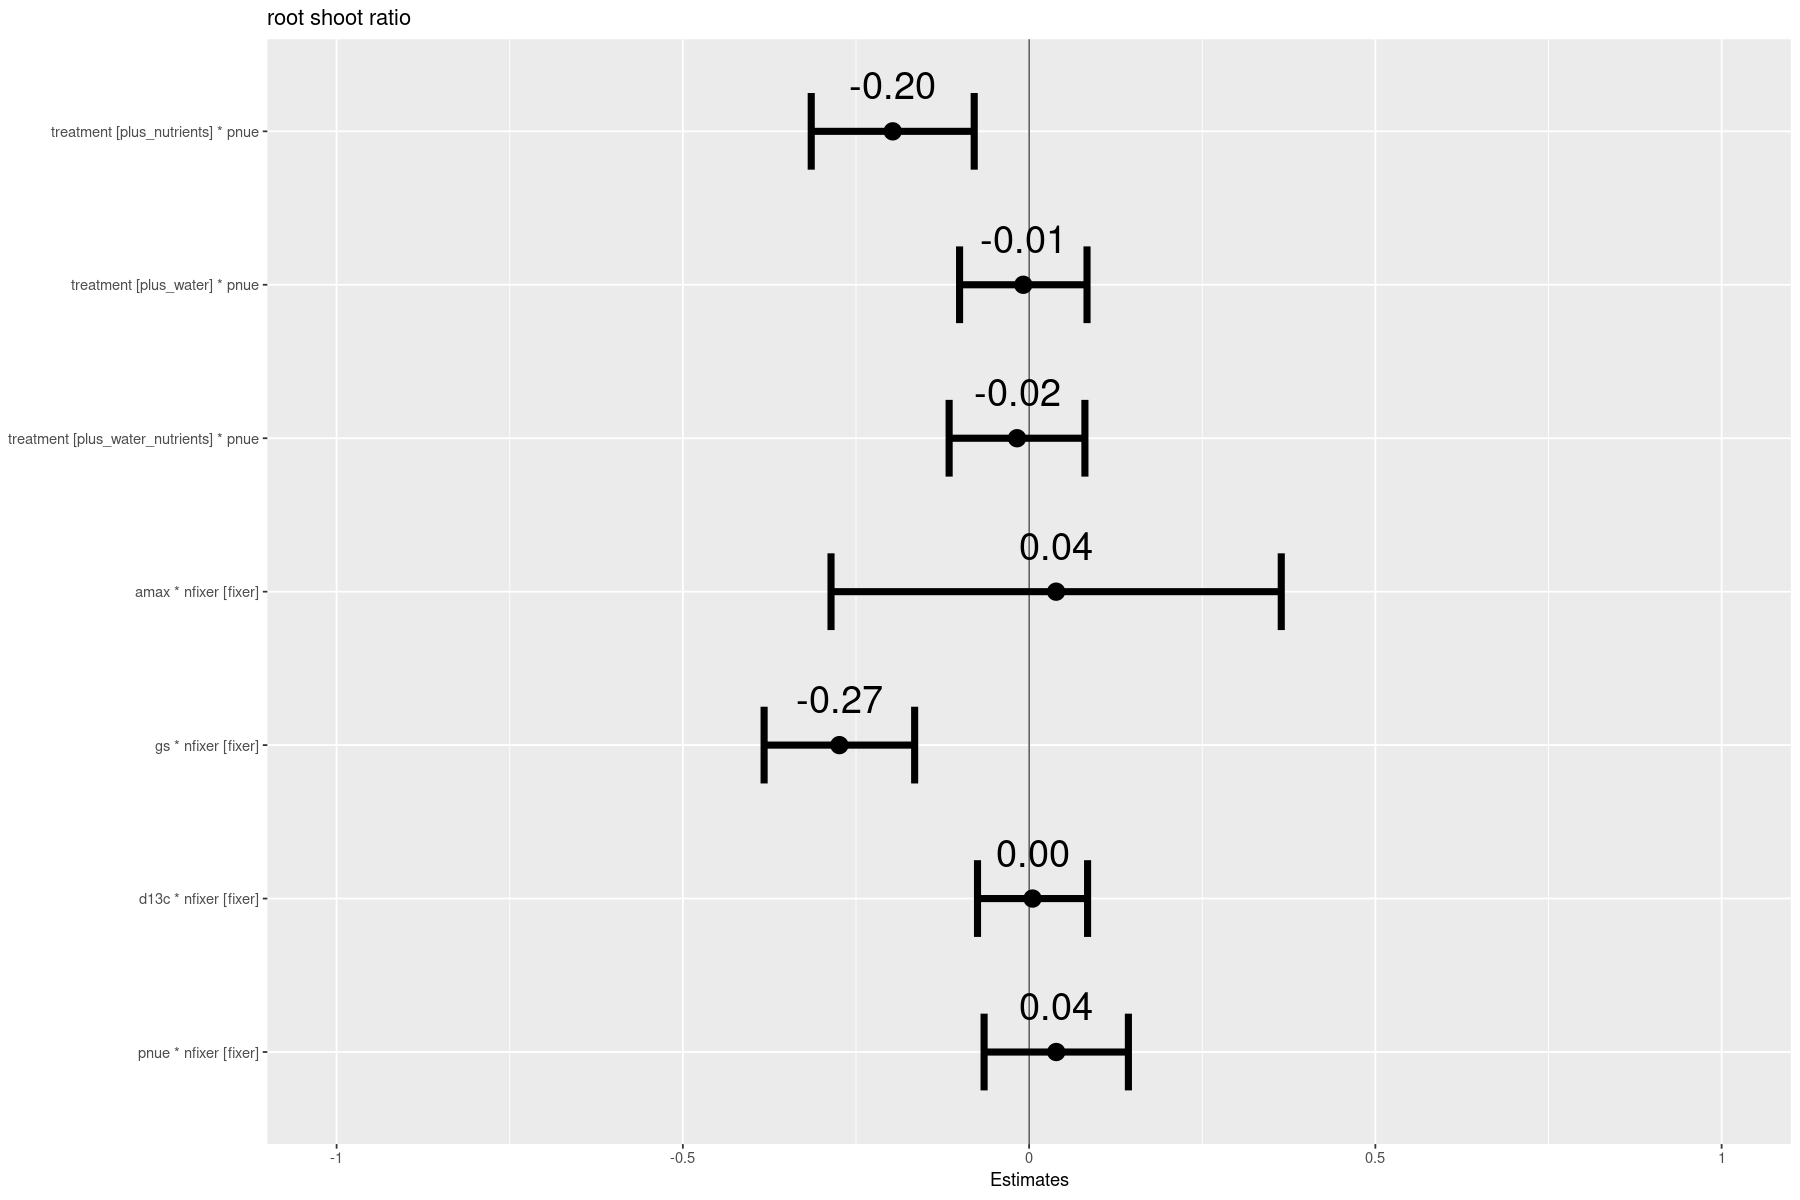

In [61]:
plot_model(model_pc_root_shoot, show.values = TRUE,

                        rm.terms = c("treatmentplus_nutrients",
                                    "treatmentplus_water",
                                    "treatmentplus_water_nutrients",
                                    "amax", "gs", "d13c",
                                    "pnue", "init_height",

                                    "nfixerfixer",

                                     "treatmentplus_nutrients:amax",
                                     "treatmentplus_water:amax",
                                     "treatmentplus_water_nutrients:amax",

                                     "treatmentplus_nutrients:gs",
                                     "treatmentplus_water:gs",
                                     "treatmentplus_water_nutrients:gs",

                                     "treatmentplus_nutrients:d13c",
                                     "treatmentplus_water:d13c",
                                     "treatmentplus_water_nutrients:d13c",

                                     "treatmentplus_nutrients:pnue",
                                     "treatmentplus_water:pnue",
                                     "treatmentplus_water_nutrients:pnue"


                        ),
                        colors = "black",
                        value.offset = .3,
                        value.size = 8,
                        dot.size = 4.5,
                        line.size = 2,
                        vline.color = "black",
                        width = 0.5,
                        show.p = FALSE,

                        )